In [1]:
%cd supervised
%load_ext autoreload
%autoreload 2

import data
import train
import evaluate
import torch

/home/maarten/Documents/masterthesis/supervised


# Dataset analysis

In [ ]:
import glob
from lxml import etree

positives = []
negatives = []
for path in glob.glob('../training_data/*.xml'):
    with open(path, 'r') as f:
        xml = etree.fromstring(f.read().encode('utf-8'))
    pos = len(xml.xpath('/pdf2xml/page/text[@is-speech="true"]'))
    neg = len(xml.xpath('/pdf2xml/page/text[@is-speech="false"]'))
    positives.append(pos)
    negatives.append(neg)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

sns.distplot(positives, axlabel='positive samples per file')
fig = plt.gcf()
plt.show()
fig.savefig('distribution.pdf')

print(tabulate([['Positives samples', sum(positives)],
                ['Negative samples', sum(negatives)]]))

# Training and evaluation

In [2]:
num_clusters = 5

files = [f'../clusterlabeled-{num_clusters}/18{i:03d}.xml' for i in range(1, 10) if i not in [8, 12]]
test_files = [f'../clusterlabeled-{num_clusters}/18{i:03d}.xml' for i in [21, 22, 23, 24, 25, 26, 27]]
source_dataset = data.GermanDataset(files, num_clusters, 20000, 10000, 3, 1)

  7%|▋         | 1356/20000 [00:07<01:44, 178.49it/s]


Retrieved 1356 positive samples, 55425 negative samples.


In [3]:
small_test_dataset = data.GermanDataset(test_files, num_clusters, 200, 400, 3, 1, vocab=source_dataset.vocab)
test_dataset = data.GermanDataset(test_files, num_clusters, 1000, 10000, 3, 1, vocab=source_dataset.vocab)

369it [00:02, 164.91it/s]                         
  0%|          | 0/1000 [00:00<?, ?it/s]

Retrieved 369 positive samples, 16465 negative samples.


1266it [00:09, 134.95it/s]                         


Retrieved 1266 positive samples, 66607 negative samples.


In [48]:
tiny_dataset = source_dataset.split((10, 10))
small_dataset = source_dataset.split((100, 100))
medium_dataset = source_dataset.split((200, 200))
large_dataset = source_dataset.split((1200, 1200))

In [32]:
params = train.CNNParams(
    embed_size=300,
    dropout=0.50,
    epochs=50,
    num_filters=100,
    kernel_size=3,
    num_layers=1
)
optimizer = lambda p: torch.optim.Adadelta(p, weight_decay=1e-3)

In [27]:
def cross_val(k, dataset, testset, use_dumb=False):
    folds = dataset.kfold(k=k)
    plain = {'F1': [], 'losses': [], 'AoC': [], 'pr': []}
    cluster = {'F1': [], 'losses': [], 'AoC': [], 'pr': []}
    only_cluster = {'F1': [], 'losses': [], 'AoC': [], 'pr': []}

    for i in range(k):
        torch.cuda.empty_cache()
        training_folds = [folds[j] for j in range(k) if j != i]
        train_set = data.ConcatDataset(training_folds)

        plain_model, plain_l = train.setup_and_train(params, with_labels=False, dataset=train_set,
                                                     epochs=params.epochs, batch_size=50, optim_fn=optimizer,
                                                     only_labels=False)
        cluster_model, cluster_l = train.setup_and_train(params, with_labels=True, dataset=train_set,
                                                         epochs=params.epochs, batch_size=50, optim_fn=optimizer,
                                                         only_labels=False)
        if use_dumb:
            dumb_model, dumb_l = train.setup_and_train(params, with_labels=True, dataset=train_set,
                                                       epochs=params.epochs, batch_size=50, optim_fn=optimizer,
                                                       only_labels=True)
            only_cluster['losses'].append(dumb_l)

        plain['losses'].append(plain_l)
        cluster['losses'].append(cluster_l)

        plain_scores = evaluate.get_scores(plain_model, testset)
        cluster_scores = evaluate.get_scores(cluster_model, testset)
        plain['F1'].append(plain_scores['F1'])
        plain['AoC'].append(plain_scores['AoC'])
        plain['pr'].append(plain_scores['pr'])
        cluster['F1'].append(cluster_scores['F1'])
        cluster['AoC'].append(cluster_scores['AoC'])
        cluster['pr'].append(cluster_scores['pr'])
        
        if use_dumb:
            dumb_scores = evaluate.get_scores(dumb_model, testset)
            only_cluster['F1'].append(dumb_scores['F1'])
            only_cluster['AoC'].append(dumb_scores['AoC'])
            only_cluster['pr'].append(dumb_scores['pr'])

        
    return plain, cluster, only_cluster

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from tabulate import tabulate

def analyze(cluster, plain, filename_prefix=None):
    print('Average convergence speed')
    ax = evaluate.plot({'Without clusters': np.mean(plain['losses'], axis=0),
                         'With clusters': np.mean(cluster['losses'], axis=0)},
                        'epoch', 'loss')
    if filename_prefix:
        plt.savefig(f'{filename_prefix}_losses.pdf')
    plt.show()
    print()

    print('Average P/R curve')
    cluster_mean_pr = evaluate.mean_of_pr([p for p, _ in cluster['pr']],
                                           [r for _, r in cluster['pr']])
    cluster_r = sorted(cluster_mean_pr.keys())
    cluster_p = [cluster_mean_pr[r] for r in cluster_r]
    plain_mean_pr = evaluate.mean_of_pr([p for p, _ in plain['pr']],
                                           [r for _, r in plain['pr']])
    plain_r = sorted(plain_mean_pr.keys())
    plain_p = [plain_mean_pr[r] for r in plain_r]

    ax = evaluate.plot({'With clusters': (cluster_p, cluster_r), 'Without clusters': (plain_p, plain_r)},
               'recall', 'precision')
    if filename_prefix:
        plt.savefig(f'{filename_prefix}_pr.pdf')
    plt.show()
    print()

    print('F1 score')
    print(tabulate([['plain', np.mean(plain['F1']), np.std(plain['F1'])],
                    ['clusters', np.mean(cluster['F1']), np.std(cluster['F1'])]],
                   headers=['', 'mean', 'stddev']))

    print()
    print('Area under precision/recall curve')
    print(tabulate([['plain', np.mean(plain['AoC']), np.std(plain['AoC'])],
                    ['clusters', np.mean(cluster['AoC']), np.std(cluster['AoC'])]],
                   headers=['', 'mean', 'stddev']))

    print()
    p = scipy.stats.ttest_ind(plain['AoC'], cluster['AoC'], equal_var=False)
    print(f'T-test probability that the AoC distributions are the same: {p.pvalue}')
    p = scipy.stats.ttest_ind(plain['AoC'], cluster['AoC'], equal_var=False)
    print(f'T-test probability that the F1 distributions are the same: {p.pvalue}')

    print('AP plots:')
    df = pd.DataFrame({'Plain': plain['AoC'], 'Cluster': cluster['AoC']})

    sns.distplot(plain['AoC'], label='Plain')
    sns.distplot(cluster['AoC'], label='Cluster')

    plt.legend()
    if filename_prefix:
        plt.savefig(f'{filename_prefix}_kde_ap.pdf')
    plt.show()

    plt.figure()
    sns.boxplot(data=df)
    if filename_prefix:
        plt.savefig(f'{filename_prefix}_boxplot_ap.pdf')
    plt.show()

    print('F1 plots:')
    df = pd.DataFrame({'Plain': plain['F1'], 'Cluster': cluster['F1']})

    sns.distplot(plain['F1'], label='Plain')
    sns.distplot(cluster['F1'], label='Cluster')

    plt.legend()
    if filename_prefix:
        plt.savefig(f'{filename_prefix}_kde_f1.pdf')
    plt.show()

    plt.figure()
    sns.boxplot(data=df)
    if filename_prefix:
        plt.savefig(f'{filename_prefix}_boxplot_f1.pdf')
    plt.show();

In [49]:
params = train.CNNParams(
    embed_size=300,
    dropout=0.50,
    epochs=50,
    num_filters=100,
    kernel_size=5,
    num_layers=1
)
optimizer = lambda p: torch.optim.Adadelta(p, weight_decay=1e-3)
plain, cluster, only_cluster = cross_val(5, tiny_dataset, small_test_dataset)

Training: 100%|██████████| 50/50 [00:01<00:00, 38.11it/s, loss=0.26, Δloss=-0.0877]   


Average convergence speed


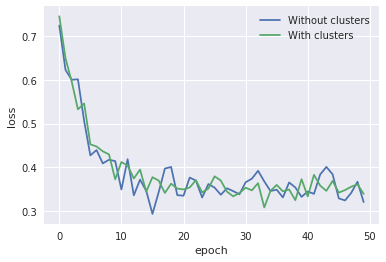


Average P/R curve


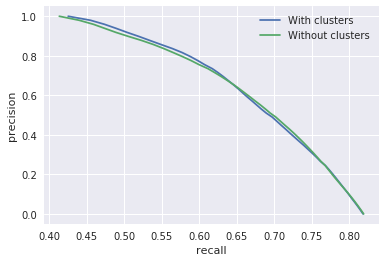


F1 score
              mean     stddev
--------  --------  ---------
plain     0.750236  0.0313798
clusters  0.753456  0.0438321

Area under precision/recall curve
              mean     stddev
--------  --------  ---------
plain     0.819014  0.0370996
clusters  0.818225  0.0491606

T-test probability that the AoC distributions are the same: 0.9802313632890599
T-test probability that the F1 distributions are the same: 0.9802313632890599
AP plots:


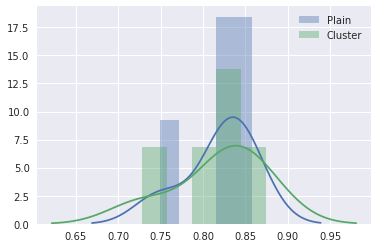

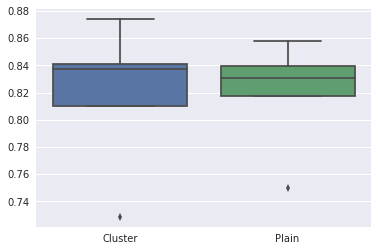

F1 plots:


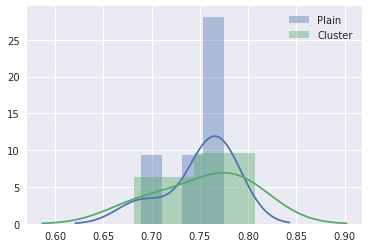

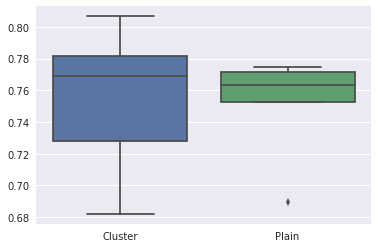

In [47]:
analyze(cluster, plain)

# Older data

This section tests the trained models on a number of files from the older wahlperiods.

In [ ]:
import os
files = os.listdir(f'../testing_data_older-{num_clusters}/')
paths = [f'../testing_data_older-{num_clusters}/' + f for f in files]
old_data = data.GermanDataset(paths, num_clusters, 10000, 10000, 3, 0, vocab=large_dataset.vocab)

In [ ]:
model = models["2400 samples"]
old_nocluster_p, old_nocluster_r = evaluate.precision_recall_values(model.without_clusters, data.get_iterator(old_data, [40]))
old_cluster_p, old_cluster_r = evaluate.precision_recall_values(model.with_clusters, data.get_iterator(old_data, [40]));

table = [['With clusters', evaluate.average_precision(old_cluster_p, old_cluster_r),
          evaluate.max_f1(old_cluster_p, old_cluster_r)],
         ['Without clusters', evaluate.average_precision(old_nocluster_p, old_nocluster_r),
          evaluate.max_f1(old_nocluster_p, old_nocluster_r)]]
print(tabulate(table, headers=['', 'Maximum F1 score', 'Average precision']))
evaluate.plot({'With clusters': (old_cluster_r, old_cluster_p), 'Without clusters': (old_nocluster_r, old_nocluster_p)},
              'recall', 'precision', title='Precision/recall curve')

# BoW baseline

In [ ]:
import nltk
files = [f'../clusterlabeled-{num_clusters}/18{i:03d}.xml' for i in range(1, 20) if i not in [8, 12]]
test_files = [f'../clusterlabeled-{num_clusters}/18{i:03d}.xml' for i in [21, 22, 23]]
bow_dataset = data.GermanDataset(files, num_clusters, 800, 1600, 3, 0, bag_of_words=True)
bow_test = data.GermanDataset(test_files, num_clusters, 10000, 10000, 3, 0, vocab=bow_dataset.vocab,
                                  bag_of_words=True)

In [ ]:
small_vocab = medium_dataset.vocab.token_to_idx
small_vocab['vvvvvv'] = 0

In [ ]:
print('Unigrams:')
svm, vectorizer = train.train_BoW(bow_dataset, small_vocab)
print(evaluate.evaluate_bow(svm, vectorizer, bow_test))

print('Bigrams:')
svm, vectorizer = train.train_BoW(bow_dataset, small_vocab, ngram_range=(1, 2))
print(evaluate.evaluate_bow(svm, vectorizer, bow_test))